**Dataset:** https://www.kaggle.com/datasets/dev0914sharma/customer-clustering?select=segmentation+data.csv

# ML Models in this notebook:
    A. KMeans
    B. DBSCAN (Density Based Spatial Clustering of Applications with Noise)
    C. OPTICS (Ordering Points To Identify Clustering Structure)
    D. Affinity Propagation

# Step 1: Import Libraries

In [1]:
# use pandas to read data
import pandas as pd

# use numpy for numeric operations (if required)
import numpy as np

# import clustering models
from sklearn.cluster import KMeans, DBSCAN, OPTICS, cluster_optics_dbscan, AffinityPropagation

# use sklearn to standardize and normalize the data
from sklearn.preprocessing import StandardScaler, normalize

# use silhouette score as clustering metric
from sklearn.metrics import silhouette_score

# Misc
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings("ignore")

# Step 2: Read and Explore Data

In [2]:
CSV_PATH = "../../../dataset/segmentation_data.csv"
raw_df = pd.read_csv(CSV_PATH)
raw_df.head(3)

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0


# Step 3: Preprocess Data

In [3]:
# Remove unwanted column(s)
raw_df.drop("ID", axis=1, inplace=True)

In [4]:
# Drop duplicates and deal with missing values
raw_df.drop_duplicates(inplace=True)

raw_df.isna().sum()

Sex                0
Marital status     0
Age                0
Education          0
Income             0
Occupation         0
Settlement size    0
dtype: int64

In [5]:
# Check for numerical and categorical columns
numerical_cols = ["Age", "Income"]
categorical_col = [col for col in raw_df.columns if col not in numerical_cols]

In [6]:
# Check datatypes of categorical columns
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Sex              2000 non-null   int64
 1   Marital status   2000 non-null   int64
 2   Age              2000 non-null   int64
 3   Education        2000 non-null   int64
 4   Income           2000 non-null   int64
 5   Occupation       2000 non-null   int64
 6   Settlement size  2000 non-null   int64
dtypes: int64(7)
memory usage: 125.0 KB


In [7]:
for col in categorical_col:
    raw_df[col] = raw_df[col].astype("category")

In [8]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Sex              2000 non-null   category
 1   Marital status   2000 non-null   category
 2   Age              2000 non-null   int64   
 3   Education        2000 non-null   category
 4   Income           2000 non-null   int64   
 5   Occupation       2000 non-null   category
 6   Settlement size  2000 non-null   category
dtypes: category(5), int64(2)
memory usage: 57.3 KB


In [9]:
# Scale and normalize the nuerical columns
scaler = StandardScaler()
raw_df[numerical_cols] = scaler.fit_transform(raw_df[numerical_cols])
raw_df[numerical_cols] = normalize(raw_df[numerical_cols])

In [12]:
# One hot encoding
df = pd.get_dummies(raw_df[categorical_col])
df[numerical_cols] = raw_df[numerical_cols].copy()

In [13]:
df.head(3)

,Sex_0,Sex_1,Marital status_0,Marital status_1,Education_0,Education_1,Education_2,Education_3,Occupation_0,Occupation_1,Occupation_2,Settlement size_0,Settlement size_1,Settlement size_2,Age,Income
0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0.999325,0.036726
1,0,1,0,1,0,1,0,0,0,1,0,0,0,1,-0.834885,0.550424
2,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0.801645,-0.597801


# Step 4: Build Models

## A. KMeans

In [14]:
# K-Means
best_cluster_size = None
best_score = 0
for cluster_size in range(100, 200, 10):
    KM = KMeans(n_clusters=cluster_size)
    KM.fit(df)
    pred = KM.predict(df)
    score = silhouette_score(df, pred, sample_size=1000, random_state=42)
    print(f"Cluster Size = {cluster_size}, Score = {score}")
    if score > best_score:
        best_score = score
        best_cluster_size = cluster_size
print(f"Best Cluster Size: {best_cluster_size}, Best Silhouette Score: {best_score}")

Cluster Size = 100, Score = 0.5851607774678853
Cluster Size = 110, Score = 0.5984980503194351
Cluster Size = 120, Score = 0.5932715309191676
Cluster Size = 130, Score = 0.6005223859469931
Cluster Size = 140, Score = 0.5910738421418971
Cluster Size = 150, Score = 0.5958770794166153
Cluster Size = 160, Score = 0.6015076549064383
Cluster Size = 170, Score = 0.5976945142205288
Cluster Size = 180, Score = 0.5900129305213022
Cluster Size = 190, Score = 0.5885178627660695
Best Cluster Size: 160, Best Silhouette Score: 0.6015076549064383


## B. DBSCAN

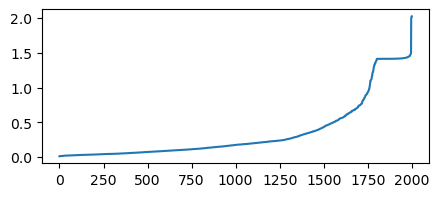

In [15]:
# Based on epsilon and minimum samples in the area of circle where radius = epsilon

# To find best value of epsilon, we use elbow curve.
# Assume nearest neighbors as 10
NN = NearestNeighbors(n_neighbors=10)
neighbors = NN.fit(df)
distances, indices = neighbors.kneighbors(df)

plt.figure(figsize=(5, 2))
plt.plot(np.sort(distances[:, 9]))
plt.xlabel = "values"
plt.ylabel = "epsilon"

In [16]:
# Referring to the plot above, elbow point is at 0.75. So epsilon E = 0.75
E = 0.75

In [17]:
# DBSCAN
DB = DBSCAN(eps=E, min_samples=10)
DB.fit(df)
pred = DB.labels_
cluster = len(np.unique(pred))
score = silhouette_score(df, pred, sample_size=1000, random_state=42)
print(f"Epsilon= {E}, Cluster Size= {cluster}, Score= {score}")

Epsilon= 0.75, Cluster Size= 38, Score= 0.46806153256101457


## C. OPTICS

In [18]:
# OPTICS: Simialr to DBSCAN, based on epsilon value
OP = OPTICS(min_samples=10)
OP.fit(df)
pred = cluster_optics_dbscan(
    reachability=OP.reachability_,
    core_distances=OP.core_distances_,
    ordering=OP.ordering_,
    eps=E,
)
cluster = len(np.unique(pred))
score = silhouette_score(df, pred, sample_size=1000, random_state=42)
print(f"Epsilon= {E}, Cluster Size= {cluster}, Score= {score}")

Epsilon= 0.75, Cluster Size= 38, Score= 0.4666427681852281


## D. Affinity Propagation

In [19]:
# Affinity Propagation, when you dont know the number of clusters.
# We use 'damping' within limits 0.5 and 1

best_d_val = 0
best_score = 0

for d_val in np.arange(0.5, 1, 0.1):
    d_val = round(d_val, 1)
    AP = AffinityPropagation(damping=d_val)
    AP.fit(df)
    pred = AP.predict(df)
    cluster = len(np.unique(pred))
    score = silhouette_score(df, pred, sample_size=1000, random_state=42)
    print(f"Damping= {d_val}, Cluster Size= {cluster}, Score= {score}")
    if score > best_score:
        best_score = score
        best_d_val = d_val
        
print(f"Best Damping Value = {best_d_val} and Score = {best_score}")

Damping= 0.5, Cluster Size= 431, Score= 0.41228891032417164
Damping= 0.6, Cluster Size= 297, Score= 0.5168322390224634
Damping= 0.7, Cluster Size= 84, Score= 0.5807693283940688
Damping= 0.8, Cluster Size= 84, Score= 0.5843712687785615
Damping= 0.9, Cluster Size= 84, Score= 0.5836650845989586
Best Damping Value = 0.8 and Score = 0.5843712687785615


---
# Author
Name: Shounak Deshpande <br>
Email: shounak.python@gmail.com